In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/My Drive/AGIT Booctamp/Vehicle Classifer V3/Result

/content/drive/My Drive/AGIT Booctamp/Vehicle Classifer V3/Result


In [7]:
import torch
from torch import nn, optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from PIL import Image

import time
import os
import copy

In [8]:
X = np.load("imageMobilIndo_299x299.npy", allow_pickle=True)
Y = np.load("labelMobilIndo_299x299.npy", allow_pickle=True)

In [9]:
sorted_y = sorted(set(Y))
label = {label : ind for ind, label in enumerate(sorted_y)}
Y = [label[val] for val in Y]
Y = np.array(Y)

In [10]:
class_names = {val :  key  for key, val in label.items()}
# class_names

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state=42)

print("Data Train Shape")
print("Data Train : ", X_train.shape)
print("Label Train : ", Y_train.shape)
print("==========================================")

print("Data Validation Shape")
print("Data Vaidation: ", X_val.shape)
print("Label Vaidation: ", Y_val.shape)
print("==========================================")

Data Train Shape
Data Train :  (5925, 299, 299, 3)
Label Train :  (5925,)
Data Validation Shape
Data Vaidation:  (2540, 299, 299, 3)
Label Vaidation:  (2540,)


In [12]:

data_transforms = {
    'train' : transforms.Compose([
          # transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
    'val': transforms.Compose([
          # transforms.Resize(256),
          # transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [13]:
def MyDataset(img, transforms = data_transforms):
  x = Image.fromarray(img)
  x = transforms['train'](x)
  x = x.numpy()
  return x


In [14]:
X_train = list(map(MyDataset, X_train))
X_val = list(map(MyDataset, X_val))

image_datasets = {}

image_datasets['train'] = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
image_datasets['val'] = torch.utils.data.TensorDataset(torch.tensor(X_val), torch.tensor(Y_val))

In [15]:
BATCH_SIZE = 4
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


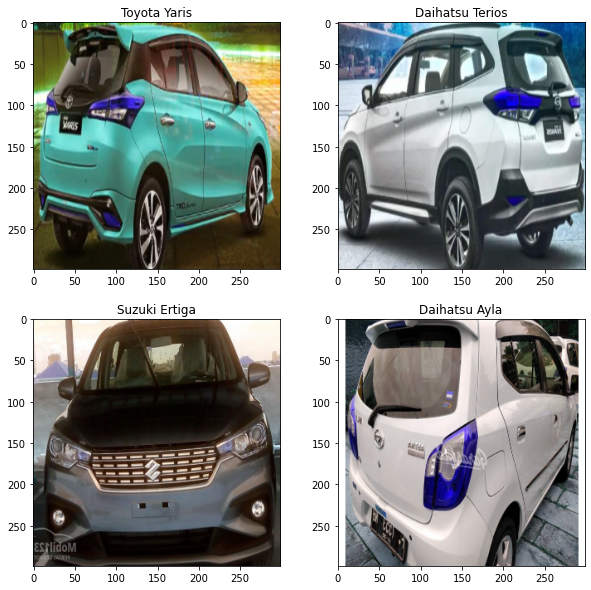

In [32]:
for images, labels in dataloaders['train']:
  fig, ax = plt.subplots(2, 2)
  fig.set_size_inches(10, 10)
  cont = 0
  for row in range(2):
    for col in range(2):
      img  = images[cont].numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      img = std * img + mean
      ax[row, col].imshow(img)
      ax[row, col].set_title(class_names[labels[cont].item()])
      cont += 1
  break

(303, 1206, 3)


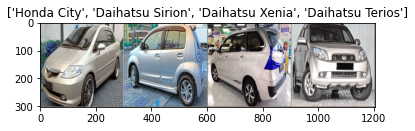

In [17]:
def imshow(inp, title = None):
  # imshow for Tensor
  inp = inp.numpy().transpose((1, 2, 0))
  print(inp.shape)
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

#get batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j].item()]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(sorted_y))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.2120 Acc: 0.2128
val Loss: 1.7147 Acc: 0.5343

Epoch 1/24
----------
train Loss: 1.4687 Acc: 0.6174
val Loss: 0.8238 Acc: 0.7780

Epoch 2/24
----------
train Loss: 0.7023 Acc: 0.8255
val Loss: 0.6636 Acc: 0.8217

Epoch 3/24
----------
train Loss: 0.3636 Acc: 0.9197
val Loss: 0.5355 Acc: 0.8594

Epoch 4/24
----------
train Loss: 0.2016 Acc: 0.9624
val Loss: 0.4859 Acc: 0.8756

Epoch 5/24
----------
train Loss: 0.1171 Acc: 0.9796
val Loss: 0.4612 Acc: 0.8886

Epoch 6/24
----------
train Loss: 0.0910 Acc: 0.9875
val Loss: 0.4506 Acc: 0.8858

Epoch 7/24
----------
train Loss: 0.0600 Acc: 0.9929
val Loss: 0.4026 Acc: 0.9059

Epoch 8/24
----------
train Loss: 0.0482 Acc: 0.9938
val Loss: 0.4043 Acc: 0.9055

Epoch 9/24
----------
train Loss: 0.0409 Acc: 0.9958
val Loss: 0.4134 Acc: 0.9004

Epoch 10/24
----------
train Loss: 0.0434 Acc: 0.9956
val Loss: 0.3974 Acc: 0.9067

Epoch 11/24
----------
train Loss: 0.0365 Acc: 0.9963
val Loss: 0.3856 Acc: 0.9091

Ep

(299, 299, 3)


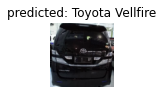

(299, 299, 3)


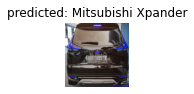

(299, 299, 3)


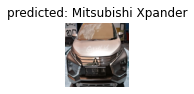

(299, 299, 3)


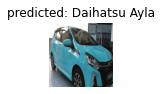

(299, 299, 3)


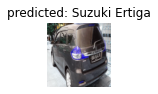

(299, 299, 3)


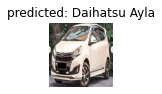

In [22]:
visualize_model(model_ft)

### Save model

In [27]:
PATH = 'model Pytorch'
try:
  os.mkdir(PATH)
except:
  pass  

PATH = f'{PATH}/vehicle_classifier_resnet18.pth'
torch.save(model_ft.state_dict(), PATH)

In [29]:
import json
PATH = 'model Pytorch'

with open(f'{PATH}/class_names.json', 'w') as outfile:
    json.dump(class_names, outfile, indent=4)

### ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False `` to freeze the parameters so that the gradients are not computed in ``backward().``

In [23]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(label))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.9576 Acc: 0.0668
val Loss: 3.4175 Acc: 0.1709

Epoch 1/24
----------
train Loss: 3.3650 Acc: 0.1789
val Loss: 3.0192 Acc: 0.2386

Epoch 2/24
----------
train Loss: 3.0142 Acc: 0.2538
val Loss: 2.7140 Acc: 0.3232

Epoch 3/24
----------
train Loss: 2.7625 Acc: 0.3095
val Loss: 2.5786 Acc: 0.3453

Epoch 4/24
----------
train Loss: 2.5907 Acc: 0.3450
val Loss: 2.3868 Acc: 0.3878

Epoch 5/24
----------
train Loss: 2.4516 Acc: 0.3745
val Loss: 2.2521 Acc: 0.4189

Epoch 6/24
----------
train Loss: 2.3289 Acc: 0.4059
val Loss: 2.2102 Acc: 0.4346

Epoch 7/24
----------
train Loss: 2.0571 Acc: 0.5024
val Loss: 2.0684 Acc: 0.4701

Epoch 8/24
----------
train Loss: 2.0259 Acc: 0.5185
val Loss: 2.0379 Acc: 0.4705

Epoch 9/24
----------
train Loss: 2.0266 Acc: 0.5141
val Loss: 2.0137 Acc: 0.4748

Epoch 10/24
----------
train Loss: 2.0125 Acc: 0.5185
val Loss: 2.0253 Acc: 0.4713

Epoch 11/24
----------
train Loss: 2.0202 Acc: 0.5178
val Loss: 2.0408 Acc: 0.4614

Ep

(299, 299, 3)


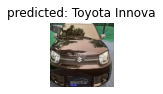

(299, 299, 3)


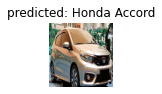

(299, 299, 3)


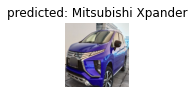

(299, 299, 3)


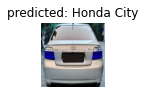

(299, 299, 3)


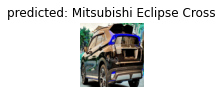

(299, 299, 3)


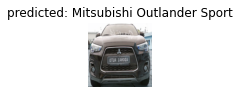

In [25]:
visualize_model(model_conv)